In this notebook we show how to use the new deepymod code and phimal utilities to load data and perform data analysis:

In [12]:
import numpy as np
import pandas as pd
import torch

from DeePyMoD_SBL.deepymod_torch.library_functions import library_1D_in
from DeePyMoD_SBL.deepymod_torch.DeepMod import DeepModDynamic
from DeePyMoD_SBL.deepymod_torch.training import train_dynamic_logprob_scaled
from sklearn.linear_model import LassoLarsIC, LarsCV


import time
from DeePyMoD_SBL.deepymod_torch.output import Tensorboard, progress
from DeePyMoD_SBL.deepymod_torch.losses import reg_loss, mse_loss, l1_loss
from DeePyMoD_SBL.deepymod_torch.sparsity import scaling, threshold
from numpy import pi

from phimal_utilities.data import Dataset
from phimal_utilities.data.burgers import BurgersDelta
from phimal_utilities.analysis import load_tensorboard

if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import time
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Making data

In [3]:
data = np.load('kdv.npy', allow_pickle=True).item()
print('Shape of grid:', data['x'].shape)

Shape of grid: (512, 201)


Create a dataset by giving your solution to the object and its parameters (make sure they're named)

In [4]:
X = np.transpose((data['t'].flatten(), data['x'].flatten()))
y = np.real(data['u']).reshape((data['u'].size, 1))
print(X.shape, y.shape)
noise_level = 0.20
y_noisy = y + noise_level * np.std(y) * np.random.randn(y[:,0].size, 1)
number_of_samples = 3000

idx = np.random.permutation(y.shape[0])
X_train = torch.tensor(X[idx, :][:number_of_samples], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y_noisy[idx, :][:number_of_samples], dtype=torch.float32)

(102912, 2) (102912, 1)


# Running deepmod

Now we show how to use the new deepmod. We first define which sparsity estimator we want to use. All estimators from scikitlearn are fine. set fit_intercept to false as that term is in our model.

In [5]:
estimator = LarsCV(fit_intercept=False)

Then we define the config and build the model as always:

In [6]:
config = {'n_in': 2, 'hidden_dims': [50, 50, 50, 50, 50], 'n_out': 1, 'library_function':library_1D_in, 'library_args':{'poly_order': 2, 'diff_order': 3}, 'sparsity_estimator': estimator}
model = DeepModDynamic(**config)


#In the future, I want to change the api so that we would do the following:
'''
function_approximator = network(n_in=2, hidden_dims=[30, 30, 30, 30, 30], n_out=1)
library = Library(function=library_1D_in, poly_order=2, deriv_order=2)
sparse_estimator = Estimator(fit_intercept=False)

model = DeepMoD(function_approximator, library, sparse_estimator)
'''
# main reason is not to get a massive config dictionary which is not very clear. This would also be super flexible.

'\nfunction_approximator = network(n_in=2, hidden_dims=[30, 30, 30, 30, 30], n_out=1)\nlibrary = Library(function=library_1D_in, poly_order=2, deriv_order=2)\nsparse_estimator = Estimator(fit_intercept=False)\n\nmodel = DeepMoD(function_approximator, library, sparse_estimator)\n'

Define the optimizer:

In [7]:
optimizer = torch.optim.Adam(model.network_parameters(), amsgrad=True)

And train for 15k:. We start the sparsity update after 5000 iterations so we have a good estimate of the data and update it every 200 iterations after:

In [14]:
# Defining training function
def train(model, data, target, optimizer, max_iterations, loss_func_args, log_dir=None):
    start_time = time.time()
    number_of_terms = [coeff_vec.shape[0] for coeff_vec in model(data)[3]]
    board = Tensorboard(number_of_terms, log_dir)
    
    # Training
    print('| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       LL |')
    for iteration in torch.arange(0, max_iterations + 1):
        # Calculating prediction and library and scaling
        prediction, time_deriv_list, sparse_theta_list, coeff_vector_list, theta = model(data)
        coeff_vector_scaled_list = scaling(coeff_vector_list, sparse_theta_list, time_deriv_list) 
        
        # Calculating loss
        loss_mse = mse_loss(prediction, target)
        loss_reg = reg_loss(time_deriv_list, sparse_theta_list, coeff_vector_list)
        loss_ll = torch.log(2 * pi * loss_mse)
        loss_ll_fit = torch.log(2 * pi * loss_mse) + loss_reg / loss_mse
        loss = torch.sum(loss_ll) + torch.sum(loss_ll_fit)
        
        # Writing
        if iteration % 100 == 0:
            # Write progress to command line
            progress(iteration, start_time, max_iterations, loss.item(), torch.sum(loss_mse).item(), torch.sum(loss_reg).item(), torch.sum(loss_ll).item())
            
            # Calculate error for theta
            
            # Write to tensorboard
            board.write(iteration, loss, loss_mse, loss_reg, loss_ll, coeff_vector_list, coeff_vector_scaled_list)

        # Optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    board.close()


In [15]:
train(model, X_train, y_train, optimizer, 25000, loss_func_args={'start_sparsity_update': 3000, 'sparsity_update_period': 250})

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       LL |
      25000    100.00%               0s   -1.18e+01   4.34e-04   5.98e-06   -5.91e+00 

We get the following coefficients from the sparsity model (which are biased by the l1):

In [20]:
torch.tensor(X)

tensor([[  0.0000, -30.0000],
        [  0.1000, -30.0000],
        [  0.2000, -30.0000],
        ...,
        [ 19.8000,  29.8828],
        [ 19.9000,  29.8828],
        [ 20.0000,  29.8828]], dtype=torch.float64)

In [21]:
solution = model(torch.tensor(X, dtype=torch.float32, requires_grad=True))

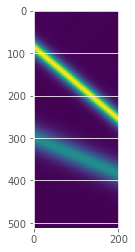

In [22]:
plt.imshow(solution[0].cpu().detach().numpy().reshape(data['x'].shape))

/opt/conda/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


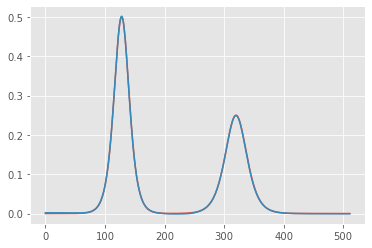

In [23]:
plt.plot(data['u'].reshape(data['x'].shape)[:,50])
plt.plot(solution[0].cpu().detach().numpy().reshape(data['x'].shape)[:,50])

In [17]:
model.constraints.sparsity_mask


[tensor([False,  True,  True,  True,  True,  True, False, False, False,  True,
          True,  True])]

In [18]:
model.sparsity_estimator.coef_

array([ 0.        , -0.13874751,  0.00258826, -0.83956189, -0.00254154,
       -1.50947243,  0.        ,  0.        ,  0.        , -0.01159605,
       -0.0161077 ,  0.03622867])

The unbiased coefficients we get from the network by:

In [19]:
model.constraints.coeff_vector

[tensor([[-0.1390],
         [-0.8524],
         [-4.7745],
         [-0.9714],
         [-0.0761]], grad_fn=<MmBackward>)]

It has one extra term, but its super small. Thats an issue for next time. This is done with 10% noise.

# Analysing

To analyse more in depth, we can load the tensorboard file:

In [53]:
# right now works with file path, will change to experiment_ID 
df = load_tensorboard('runs/Apr22_16-06-14_4b6076e78386/')

In [54]:
df.head(5)

,Total_loss,MSE_0,Regression_0,L1_0,coeff_0_0,coeff_0_1,coeff_0_2,coeff_0_3,coeff_0_4,coeff_0_5,...,coeff_0_8,scaled_coeff_0_0,scaled_coeff_0_1,scaled_coeff_0_2,scaled_coeff_0_3,scaled_coeff_0_4,scaled_coeff_0_5,scaled_coeff_0_6,scaled_coeff_0_7,scaled_coeff_0_8
0,0.051412,0.051405,0.000007,0.000007,0.012150,-0.325502,-0.853040,-0.853617,11.300903,-7.467178,...,110.875488,0.857205,-0.397089,-0.692373,-1.903975,0.736789,-0.180344,1.055231,0.070499,0.209822
100,0.013880,0.013007,0.000874,0.000874,-0.016194,-0.187640,0.001426,0.086010,-0.824461,0.361347,...,-0.707848,-0.329426,-0.605109,0.004689,0.386760,-0.568317,0.370190,-0.225219,0.556316,-0.279357
200,0.006283,0.005862,0.000421,0.000421,0.009538,-0.232684,0.037852,0.233261,0.411873,-0.211583,...,-0.275103,0.182986,-0.945609,0.219352,1.061824,0.489359,-0.503140,-1.754082,-0.560536,-0.320851
300,0.003656,0.003487,0.000170,0.000170,0.012385,-0.105834,0.012952,-0.071539,-0.746077,0.346926,...,-0.680861,0.213806,-0.407004,0.091915,-0.272326,-0.954558,1.170330,-0.047470,0.460189,-1.240764
400,0.001758,0.001608,0.000150,0.000150,0.008800,-0.120296,0.024360,-0.004866,-0.542959,0.208395,...,-0.368399,0.106491,-0.367870,0.160300,-0.013724,-0.646523,0.754378,-0.301574,0.097489,-0.862853


All the keys are:

In [55]:
df.keys()

Index(['Total_loss', 'MSE_0', 'Regression_0', 'L1_0', 'coeff_0_0', 'coeff_0_1',
       'coeff_0_2', 'coeff_0_3', 'coeff_0_4', 'coeff_0_5', 'coeff_0_6',
       'coeff_0_7', 'coeff_0_8', 'scaled_coeff_0_0', 'scaled_coeff_0_1',
       'scaled_coeff_0_2', 'scaled_coeff_0_3', 'scaled_coeff_0_4',
       'scaled_coeff_0_5', 'scaled_coeff_0_6', 'scaled_coeff_0_7',
       'scaled_coeff_0_8'],
      dtype='object')

We plot the losses:

Text(0.5, 1.0, 'Regression')

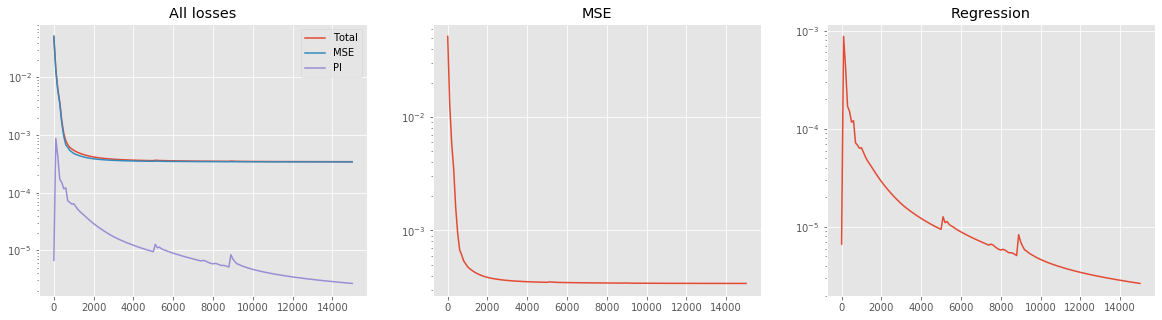

In [56]:
plt.figure(figsize=(20, 5))

plt.subplot(131)
plt.semilogy(df.index, df['Total_loss'], label='Total')
plt.semilogy(df.index, df['MSE_0'], label='MSE')
plt.semilogy(df.index, df['Regression_0'], label='PI')
plt.title('All losses')
plt.legend()

plt.subplot(132)
plt.semilogy(df.index, df['MSE_0'], label='MSE')
plt.title('MSE')

plt.subplot(133)
plt.semilogy(df.index, df['Regression_0'], label='PI')
plt.title('Regression')

Now let's look at the coefficients:

In [57]:
coeff_keys = [key for key in df.keys() if key[:5]=='coeff']
scaled_coeff_keys = [key for key in df.keys() if key[:6]=='scaled']

Text(0.5, 1.0, 'Coefficients')

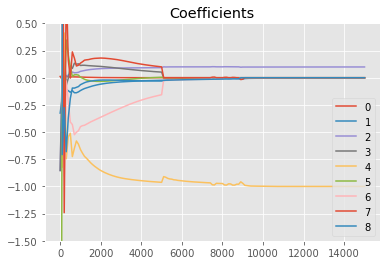

In [63]:
for key in coeff_keys:
    plt.plot(df[key], label=f'{key[-1]}')
plt.legend()
plt.ylim([-1.5, 0.5])
plt.title('Coefficients')

Text(0.5, 1.0, 'Scaled coefficients')

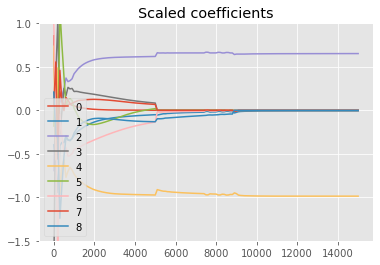

In [61]:
for key in scaled_coeff_keys:
    plt.plot(df[key], label=f'{key[-1]}')
plt.legend()
plt.ylim([-1.5, 1])
plt.title('Scaled coefficients')

So we do see a few kinks but not many and certainly with minimal effect. We can also check when terms in are the model:

In [104]:
in_model = []
for key in scaled_coeff_keys:
    in_model.append(df[key].to_numpy()[:, None])
in_model = np.concatenate(in_model, axis=1)
in_model[np.abs(in_model) > 0 ]= 1

Text(0.5, 1, 'Heatmap of coefficients in model')

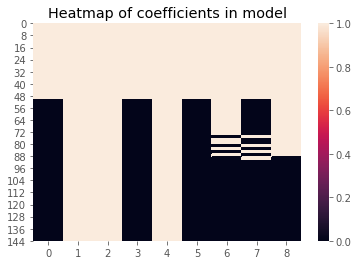

In [106]:
sns.heatmap(in_model)
plt.title('Heatmap of coefficients in model')